In [59]:
!pip install pymc3

In [1]:
%matplotlib inline
import pymc3 as pm
from pymc3.ode import DifferentialEquation
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import arviz as az
import theano
import pandas as  pd

plt.style.use('seaborn-darkgrid')

In [2]:
data = pd.read_csv("owid-covid-data.csv")
data = data[data.iso_code=="FRA"]
data = data[data.date>='2020-04-01'] # t0 = -30
popFRA = 67*10^6 

In [3]:
def ODE (y,t,lambda_,alpha,p,theta,gamma, mu,mu1,mu2,t1,t2):
    S,E,I,A,R,D = y

    # transição de mu1 para mu2 
    mu = ( ( (np.tanh(-t + t2) + 1 )/2 ) * abs(mu1 - mu2) ) + mu2
    
    
    # período de isolamento com queda de lambda_ entre t1 e t2, início e fim do lockdown respectivamente
    factor = (1 - (1 + np.tanh(t - t1)) * (1 - np.tanh(t - t2) ) )
    if factor >= 0:
        lambda_ = lambda_ * factor
    
    return [-lambda_*S*I,
            lambda_*S*I - alpha*E,
            (1-p)*alpha*E - gamma*I - mu*I,
            p*alpha*E - theta*A,
            gamma*I + theta*A,
            mu*I ]

In [4]:
lambda_ = 0.18
alpha = 0.2
p = 0.5
theta = 0.5
gamma = 0.15
mu = 0.05
mu1 = 0.05
mu2 = 0.05
# t0 = -30  
t1 = 55
t2 = 110
# obtidos do interact

In [5]:
times = np.arange(0, len(data)+1, 1)
inits = [.99, 0,.001, 0, 0, 0]
    
# Gerando curvas simuladas
y = odeint(ODE, t=times, y0=inits, args=(lambda_,alpha,p,theta,gamma,mu,mu1,mu2,t1,t2), rtol=1e-8)

# Simulando dados  Assumindo uma distribuição log-normal com média igual às séries simuladas
cases = data.total_cases
deaths = data.total_deaths

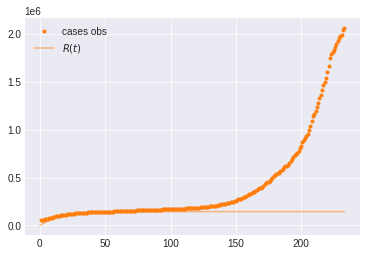

In [6]:
plt.plot(times[1::],cases,color='C1', marker='.', linestyle='none',label = f'cases obs')
plt.plot(times, y[:, -2]*popFRA, color='C1', alpha=0.5, label=f'$R(t)$')
plt.legend()
plt.savefig('cases.png');

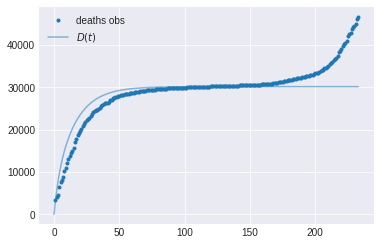

In [7]:
plt.plot(times[1::],deaths,color='C0', marker='.', linestyle='none',label = f'deaths obs')
plt.plot(times, y[:, -1]*popFRA, color='C0', alpha=0.5, label=f'$D(t)$')
plt.legend()
plt.savefig('deaths.png');

-------------------------------------------------------------------------------------------------------------------

In [8]:
def ODE (y,t,p):
    
    S,E,I,A,R,D = y
    lambda_,alpha,p,theta,gamma, mu,mu1,mu2,t1,t2 = p
    
    # transição de mu1 para mu2 
    mu = ( ( (np.tanh(-t + t2) + 1 )/2 ) * abs(mu1 - mu2) ) + mu2
    
    # período de isolamento com queda de lambda_ entre t1 e t2, início e fim do lockdown respectivamente
    factor = (1 - (1 + np.tanh(t - t1)) * (1 - np.tanh(t - t2) ) )
    if factor >= 0:
        lambda_ = lambda_ * factor
        
    return [-lambda_*S*I,
            lambda_*S*I - alpha*E,
            (1-p)*alpha*E - gamma*I - mu*I,
            p*alpha*E - theta*A,
            gamma*I + theta*A,
            mu*I ]

In [9]:
sir_model = DifferentialEquation(
    func=ODE,
    times=times,
    n_states=6,
    n_theta=10,
    t0=0,
)

ValueError: length not known: y [id A]
